# Quadcopter Robust Control Under Wind

#### Disturbance Observer-based method for wind-disturbance compensation has been implemented here, on Crazyflie2.1 Nanocopter. This setup can be said to lie inside the framework of LQR/LQG. The wind has been modeled as a random walk process, that is estimated using Kalman Filter algorithm and fed-back to the control inputs with the intention of pre-compensating for predicted/estimated wind disturbance at the next step.

The choice of wind-velocities for Linearization turns out to determine the "degree" of extra compensation on top of Vanilla LQR(i.e. without any estimation): Degree of compensation provided by DOb over Vanilla LQR is proportional to how far off of [0; 0; 0] m/s (Wind Disturbance), the linearization point was chosen.


The DOb architecture does not provide added advantage over Vanilla-LQR when the Linearization was done around, for instance, [-4, -4, 2] m/s of wind-velocity, and the actual wind (I made it not deviate too much from this value) was on the other side of zero, i.e., [4,4,1] m/s. (The Vanilla-LQR went with the wind. The DOb-LQR went on the opposite side of the setpoint and gave steady-state error, there.)


When ground-truth wind matches Linearization Point’s wind velocity, Dob provides no improvement over Vanilla LQR controller.
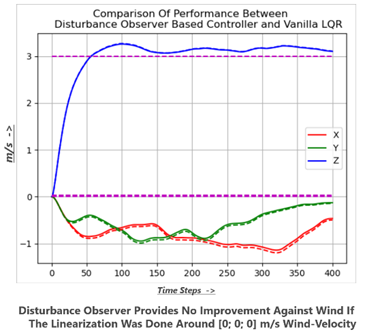
This is because the choice of wind-vector for linearization directly affects the terms within the K matrix that map the observed disturbance back onto the control inputs.

## Importing Packages:

In [1]:

import Pkg; Pkg.add("StaticArrays")
Pkg.add("GeometryBasics")
Pkg.add("Colors")

    Updating registry at `C:\Users\sdabir\.julia\registries\General.toml`
   Resolving package versions...
┌ Warning: The active manifest file at `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.7\Pkg\src\manifest.jl:287
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml:0
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
 

In [2]:
Pkg.activate(@__DIR__); Pkg.instantiate()
Pkg.add("BlockDiagonals")
Pkg.add("OSQP")
Pkg.add("ControlSystems")
Pkg.add("Quaternions")
Pkg.add("TrajOptPlots")
Pkg.add("CoordinateTransformations")
Pkg.add("Rotations")
using LinearAlgebra
using ForwardDiff
using BlockDiagonals
using ControlSystems
using RobotDynamics
using Plots
using TrajOptPlots
using StaticArrays
using SparseArrays
using Printf
using Test
using MeshCat
using GeometryBasics
using Colors
using CoordinateTransformations, Rotations, StaticArrays
using Quaternions
using OSQP

  Activating project at `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\

In [3]:
Pkg.add("Plots")
Pkg.add("PyPlot")
using Plots
using PyPlot

   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`


## Function Definitions:

### Quaternions>>

In [4]:
Pkg.add("PyCall")
using PyCall
np = pyimport("numpy")

   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`


PyObject <module 'numpy' from 'C:\\Users\\sdabir\\.julia\\conda\\3\\lib\\site-packages\\numpy\\__init__.py'>

In [5]:
# Quaternion
# Hat for Cross Product
function hat(v)
    return [0 -v[3] v[2]; v[3] 0 -v[1]; -v[2] v[1] 0]
end

# Left Multiplier of Quaternion
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s -v'; v (s * I + hat(v))]
    return L
end

function R_trans(q)
    s = q[1]
    v = q[2:4]
    L = [s -v'; v (s * I - hat(v))]
    return L'
end


T = Diagonal([1; -ones(3)])

H = [zeros(1,3); I]

# Quaternion to Rotation
function qtoQ(q)
    return  H'*T*L(q)*T*L(q)*H #<-this was in OCRL project #H'*T*R_trans(q)*T*L(q)*H
end

# Attitude Jacobian
function G(q)
    G = L(q) * H
end

# Rodrigues Parameter Represntation to Quaternion
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end

# Cayley Map (Quaternion to Rodrigues Parameters)
function qtorp(q)
    q[2:4]/q[1]
end

# Euler Angles to Quaternion
function eultoq(ϕ)
    cr = cos(0.5 * ϕ[1])
    sr = sin(0.5 * ϕ[1])
    cp = cos(0.5 * ϕ[2])
    sp = sin(0.5 * ϕ[2])
    cy = cos(0.5 * ϕ[3])
    sy = sin(0.5 * ϕ[3])
    
    qw = (cr * cp * cy) + (sr * sp * sy)
    qx = (sr * cp * cy) - (cr * sp * sy)
    qy = (cr * sp * cy) + (sr * cp * sy)
    qz = (cr * cp * sy) - (sr * sp * cy)
    return [qw; qx; qy; qz]
end

# Quaternion to Euler Angles
function qtoeul(q)
    roll = atan(2*(q[1]*q[2] + q[3]*q[4]), 1-2*(q[2]*q[2] + q[3]*q[3]))
    pitch = asin(2*(q[1]*q[3] - q[4]*q[2]))
    yaw = atan(2*(q[1]*q[4] + q[2]*q[3]), 1-2*(q[3]*q[3] + q[4]*q[4]))
    return [roll; pitch; yaw]
end 

qtoeul (generic function with 1 method)

### X-Cell 60 Heli Parameters>>

In [6]:
#=

# Helicopter Parameters
# Mass
M = 8.2 #kg

# Inertia
Ixx = 0.18 #kg m^2
Iyy = 0.34 #kg m^2
Izz = 0.28 #kg m^2
J = Diagonal([Ixx, Iyy, Izz])

# Main Rotor
hmr = 0.235 #m
Ωmr = 167 #rad/s
Rmr = 0.775 #m

# Surface Area
Sx_fux = 0.1 #m^2
Sy_fux = 0.22 #m^2
Sz_fux = 0.15 #m^2

# Tail Rotor
ntr = 4.66 #Gear ratio of tr to mr
Ωtr = ntr * Ωmr #rad/s
Rtr = 0.13 #m
ltr = 0.91 #m
htr = 0.08 #m

# Physical Parameters
g = 9.81 #m/s^2
ρ = 1.204 #kg/m^3

=#

### Animation>>

In [7]:
# Animation
function set_heli_model!(vis::Visualizer)
    #### Note: all dimensions in metres.
    width = 0.05
    # Length:
    Ltr = 0.91
    
    # Tail Rotor:
    htr = 0.08
    Rtr = 0.13
    
    # Main Rotor
    hmr = 0.235
    Rmr = 0.775
    
    # Fuselage:
    rad_fuse = 0.20
    Rshaft = 0.01

    fuselage = Sphere(Point3(0,0.0,0.0),rad_fuse)
    #fuselage2 = Sphere(Point3(-0.15,0.0,0.0),rad_fuse)
    MainRotor = Cylinder(Point3(0.0,0.0,hmr), Point3(0.0,0.0,hmr + 0.01), Rmr)
    Rotorshaft = Cylinder(Point3(0.0,0.0,0.0), Point3(0.0,0.0,hmr), Rshaft)
    Chassis = Rect3D(Vec(-Ltr,-width/2,-width/2), Vec(Ltr,width,width)) #body diagonal of a cuboid ??
    TailRotor = Cylinder(Point3(-Ltr,-0.04,htr), Point3(-Ltr,0.04,htr), Rtr)


    setobject!(vis["geom"]["fuselage"], fuselage, MeshPhongMaterial(color=colorant"gray"))
    #setobject!(vis["geom"]["fuselage2"], fuselage2, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["MainRotor"], MainRotor, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["geom"]["Rotorshaft"], Rotorshaft, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["Chassis"], Chassis, MeshPhongMaterial(color=colorant"blue"))
    setobject!(vis["geom"]["TailRotor"], TailRotor, MeshPhongMaterial(color=colorant"black"))
    
    return Nothing
end


function animate(vis, X, T, h)
    anim = MeshCat.Animation(Int(1/h))
    for t=1:size(thist,1) #10000
        atframe(anim, t) do
            #trans = Translation(10.0,0.0,0.0)
            ##
            trans = Translation(X[1,t],X[2,t],X[3,t])
            Q = qtoQ(X[4:7,t])
            rot = LinearMap(qtoQ([0.0,1.0,0.0,0.0]) * Q)
            settransform!(vis, trans ∘ rot)
            ##   
        end
    end
    return anim
end

# Wind Vector
function set_wind_model!(vis::Visualizer)
    #### Note: all dimensions in metres.
    width = 0.05
    # Length:
    Ltr = 0.91
    
    # Tail Rotor:
    htr = 0.08
    Rtr = 0.13
    
    # Main Rotor
    hmr = 0.235
    Rmr = 0.775
    
    # Fuselage:
    rad_fuse = 0.20
    Rshaft = 0.01

    #fuselage = Sphere(Point3(0,0.0,0.0),rad_fuse)
    #fuselage2 = Sphere(Point3(-0.15,0.0,0.0),rad_fuse)
    #MainRotor = Cylinder(Point3(0.0,0.0,hmr), Point3(0.0,0.0,hmr + 0.01), Rmr)
    #Rotorshaft = Cylinder(Point3(0.0,0.0,0.0), Point3(0.0,0.0,hmr), Rshaft)
    Chassis = Rect3D(Vec(-Ltr,-width/2,-width/2), Vec(Ltr,width,width)) #body diagonal of a cuboid ??
    TailRotor = Cylinder(Point3(-Ltr,-0.04,htr), Point3(-Ltr,0.04,htr), Rtr)


    #setobject!(vis["geom"]["fuselage"], fuselage, MeshPhongMaterial(color=colorant"gray"))
    #setobject!(vis["geom"]["fuselage2"], fuselage2, MeshPhongMaterial(color=colorant"gray"))
    #setobject!(vis["geom"]["MainRotor"], MainRotor, MeshPhongMaterial(color=colorant"black"))
    #setobject!(vis["geom"]["Rotorshaft"], Rotorshaft, MeshPhongMaterial(color=colorant"gray"))
    setobject!(vis["geom"]["Chassis"], Chassis, MeshPhongMaterial(color=colorant"blue"))
    setobject!(vis["geom"]["TailRotor"], TailRotor, MeshPhongMaterial(color=colorant"black"))
    
    return Nothing
end

function animate_wind(vis, W, T, h)
    anim = MeshCat.Animation(Int(1/h))
    for t=1:size(thist,1) #10000
        atframe(anim, t) do
            #trans = Translation(10.0,0.0,0.0)
            ##
            trans = Translation(W[1,t],W[2,t],W[3,t])
            Q = qtoQ(X[4:7,t])
            rot = LinearMap(qtoQ([0.0,1.0,0.0,0.0]) * Q)
            settransform!(vis, trans ∘ rot)
            ##   
        end
    end
    return anim
end

animate_wind (generic function with 1 method)

### Plot Comparison>>

In [8]:
function comparison_plot(Z...)
    p = plot(layout=(2,2), size=(900,600))
    for z in Z
        plot!(p[1], z[3], z[1][1:end,1], label=z[4]*" x", 
            xlabel="Time (s)", ylabel="Position (m)", legend=:topright)
        plot!(p[1], z[3], z[1][1:end,2], label=z[4]*" y")
        plot!(p[1], z[3], z[1][1:end,3], label=z[4]*" z")
        
        plot!(p[2], z[3], z[1][1:end,8], label=z[4]*" u", 
            xlabel="Time (s)", ylabel="Linear Velocity (m/s)", legend=:topright)
        plot!(p[2], z[3], z[1][1:end,9], label=z[4]*" v")
        plot!(p[2], z[3], z[1][1:end,10], label=z[4]*" w")
        
        plot!(p[3], z[3], z[1][1:end,11], label=z[4]*" p", 
            xlabel="Time (s)", ylabel="Angular Velocity (rad/s)", legend=:topright)
        plot!(p[3], z[3], z[1][1:end,12], label=z[4]*" q")
        plot!(p[3], z[3], z[1][1:end,13], label=z[4]*" r")
        
        plot!(p[4], z[3][1:end-1], z[2][1:end,1], label=z[4]*" u1", 
            xlabel="Time (s)", ylabel="Control Inputs", legend=:topright)
        plot!(p[4], z[3][1:end-1], z[2][1:end,2], label=z[4]*" u2")
        plot!(p[4], z[3][1:end-1], z[2][1:end,3], label=z[4]*" u3")
        plot!(p[4], z[3][1:end-1], z[2][1:end,4], label=z[4]*" u4")
    end
    p
end



comparison_plot (generic function with 1 method)

### Simulation Parameters>>

In [9]:
# Simulation Parameters
h = 0.05    # Time step

Nx = 19      # Number of States (Quaternion)
Nx̃ = 18      # Number of States (Linearized)
Nu = 4       # Number of Controls

n = Nx
m = Nu

Tfinal = 20.0                                 # Final Time
Nt = Int(Tfinal/h)+1                         # Number of Time steps
thist = Array(range(0, h*(Nt-1), step = h));  

### Helicopter Dynamics>>

In [10]:
#=

# Helicopter Dynamics
function helicopter_dynamics(x, u)
    # x: [x y z Quat u v w p q r wx wy wz]'
    # u: [a b Tmr Ttr]'
    
    r = x[1:3] #x y z
    q = x[4:7]
    v = x[8:10] #u v w
    ω = x[11:13] #p q r
    w = x[14:16]
    vw = x[17:19]
    Q = qtoQ(q)
    
    # Main Rotor Forces
    Xmr = -u[3] * u[1]
    Ymr = u[3] * u[2]
    Zmr = -u[3]
    
    # Main Rotor Moments
    Lmr = Ymr * hmr
    Mmr = -Xmr * hmr

    ##### Check Qe
    Qe = 0.0005 * ρ * (Ωmr * Rmr)^2 * pi * Rmr^3
    
    # Tail Rotor Forces
    Ytr = u[4]
    
    # Tail Rotor Moments
    Ntr = -Ytr * ltr
    Ltr = Ytr * htr
    
    # Drag Forces
    ##### Complete Drag Forces
    Xfus = w[1] #uncomment to simulate wind force
    Yfus = w[2]
    Zfus = w[3]
    
    g_matrix = Q' * [0; 0; -g]
    
    ṙ = Q * v
    q̇ = 0.5 * L(q) * H * ω
    v̇ = [(v[2] * ω[3]) - (v[3] * ω[2]) - g_matrix[1] + ((Xmr + Xfus) / M);
         (v[3] * ω[1]) - (v[1] * ω[3]) + g_matrix[2] + ((Ymr + Yfus + Ytr) / M);
         (v[1] * ω[2]) - (v[2] * ω[1]) + g_matrix[3] + ((Zmr + Zfus) / M)]
    
    ω̇ = [((ω[2] * ω[3] * (Iyy - Izz)) + (Lmr + Ltr)) / Ixx;
         ((ω[1] * ω[3] * (Izz - Ixx)) + (Mmr)) / Iyy;
         ((ω[1] * ω[2] * (Ixx - Iyy)) + (-Qe + Ntr)) / Izz]
    
    return [ṙ; q̇; v̇; ω̇ ; vw; 0; 0; 0]    
end

=#

## --------------------------------------------------------------------------------------

### Crazyflie Parameters>>

In [11]:
# Crazyflie2.0 drone Parameters

# Mass
M = 0.027 #kg

# Length
Length = 0.046 #m

# Inertia
Ixx = 1.66e-5 #kg m^2
Iyy = 1.66e-5 #kg m^2
Izz = 2.93e-5 #kg m^2
J = Diagonal([Ixx, Iyy, Izz])

# Rotor
#Ωhover = 167 #rad/s

# Surface Area (need to approximate by visual/simple observation)
Sx_fux = 0.0009 #m^2 or 30mm x 30mm
Sy_fux = 0.0009 #m^2 or 30mm x 30mm
Sz_fux = Length*Length #0.0021
#Sz_fux = 0.0009 #m^2  or 30mm x 30mm

# DRAG COEFFICIENT NOT EXACTLY KNOWN! 
        ##http://mikehamer.info/assets/papers/Crazyflie%20Modelling.pdf
        ##https://www.engineeringtoolbox.com/drag-coefficient-d_627.html

## Cd of cube is standard = 0.8 ##https://www.engineeringtoolbox.com/drag-coefficient-d_627.html 
Cd = 1.17 # for Cd*0.5*rho*A*(v_rel*v_rel)

# Rotor thrust coeff?
Kf = 2.2e-8
# Rotor Moment coeff?
Km = 2e-9

# Physical Parameters
g = 9.81 #m/s^2
ρ = 1.204 #kg/m^3

1.204

### Crazyflie Dynamics>>

In [12]:
# Crazyflie Dynamics
function drone_dynamics(x, u)
    # x: [x y z Quat u v w p q r wx wy wz wxdot wydot wzdot]'
    # u: [Thrust Moment_x Moment_y Moment_z]'
    
    r = x[1:3] #x y z
    q = x[4:7] #q0 q1 q2 q3
    v = x[8:10] #u v w
    ω = x[11:13] #p q r
    w = x[14:16] #wx wy wz
    vw = x[17:19] #wxdot wydot wzdot
    Q = qtoQ(q) #Rotation matrix from Quaternion -->  World_Frame_Vector = [Q]*Body_Frame_Vector
    
    # Control Forces:
    Thr = -u[1] #Ymr = u[3] * u[2] #Xmr =  #-u[3] * u[1]
    
    # Control Moments:
    Mx = u[2]  #Mmr = -Xmr * hmr #Lmr = Ymr * hmr
    My = u[3]
    Mz = u[4]
    
    ##################################
    #Check Qe
    #Qe = 0.0005 * ρ * (Ωmr * Rmr)^2 * pi * Rmr^3
    ##################################

    # Drag Forces:
    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # Vel of A w.r.t B  == Vel_A - Vel_B (Frame of reference should be same)
    # According to my rough calculations, 18 m/s of relative velocity with above paramaters,
    #...can generate aero force of 1.5x weight of crazyflie.
    
    # wind vel in the body frame>> 
    w_b = Q' * w
    # wind vel in the body frame<<
    
    # got to take care of the sign of wind force manually! >>
    
    Xfus = sign(w_b[1] - v[1]) * (0.5*ρ*Sx_fux*Cd*(w_b[1] - v[1])*(w_b[1] - v[1]))
    Yfus = sign(w_b[2] - v[2]) * (0.5*ρ*Sy_fux*Cd*(w_b[2] - v[2])*(w_b[2] - v[2]))
    Zfus = sign(w_b[3] - v[3]) * (0.5*ρ*Sz_fux*Cd*(w_b[3] - v[3])*(w_b[3] - v[3]))
        
    #Xfus = sign(w_b[1] - v[1])*0.5*ρ*Sx_fux*Cd*(w_b[1]- v[1])*(w_b[1]- v[1])
    #Yfus = sign(w_b[2] - v[2])*0.5*ρ*Sy_fux*Cd*(w_b[2]- v[2])*(w_b[1]- v[1])
    #Zfus = sign(w_b[3] - v[3])*0.5*ρ*Sz_fux*Cd*(w_b[3]- v[3])*(w_b[1]- v[1])
    
    # got to take care of the sign of wind force manually! <<

    
    # Gravity in Body Frame:
    g_matrix = Q' * [0; 0; -g]
    
    ṙ = Q * v
    q̇ = 0.5 * L(q) * H * ω
    v̇ = [(v[2] * ω[3]) - (v[3] * ω[2]) - g_matrix[1] + ((0.0 + Xfus)/ M);
          (v[3] * ω[1]) - (v[1] * ω[3]) + g_matrix[2] + ((0.0 + Yfus)/ M);
          (v[1] * ω[2]) - (v[2] * ω[1]) + g_matrix[3] + ((Thr + Zfus) / M)]
    
    ω̇ = [((ω[2] * ω[3] * (Iyy - Izz)) + Mx) / Ixx;
          ((ω[1] * ω[3] * (Izz - Ixx)) + My) / Iyy;
          ((ω[1] * ω[2] * (Ixx - Iyy)) + Mz) / Izz]
################################################################################   
#     for helicopter:
#     v̇ = [(v[2] * ω[3]) - (v[3] * ω[2]) - g_matrix[1] + ((Xmr + Xfus) / M);
#          (v[3] * ω[1]) - (v[1] * ω[3]) + g_matrix[2] + ((Ymr + Yfus + Ytr) / M);
#          (v[1] * ω[2]) - (v[2] * ω[1]) + g_matrix[3] + ((Zmr + Zfus) / M)]
    
#     ω̇ = [((ω[2] * ω[3] * (Iyy - Izz)) + (Lmr + Ltr)) / Ixx;
#          ((ω[1] * ω[3] * (Izz - Ixx)) + (Mmr)) / Iyy;
#          ((ω[1] * ω[2] * (Ixx - Iyy)) + (-Qe + Ntr)) / Izz]
################################################################################
    
    return [ṙ; q̇; v̇; ω̇ ; vw; 0; 0; 0]   #should we model vw i.e. assumed dynamics of wind??
end


drone_dynamics (generic function with 1 method)

In [13]:
# TODO:
# Add control-input to rotor-speed conversions!

### Sensor Dynamics>>

In [14]:
# Sensor Dynamics

# r[k+1]    = r[k] + v[k]*h + 0.5*(F_drag/M)*h*h
# v[k+1]    = v[k] + (F_drag/M)*h 
# Now take jacobian of above equations with respect to vector --> [r[k];v[k];wind_vel[k];wind_acc[k]]

#=
#########################
H12 = [(h-ρ*Sx_fux*Cd*h*h) 0 0;
       0 (h-ρ*Sy_fux*Cd*h*h) 0;
       0 0 (h-ρ*Sz_fux*Cd*h*h)]

H13 = [(ρ*Sx_fux*Cd*h*h) 0 0;
       0 (ρ*Sy_fux*Cd*h*h) 0;
       0 0 (ρ*Sz_fux*Cd*h*h)]

H_kalman = [I(3) H12*Q' H13*Q' zeros(3);
            zeros(3) I(3)  zeros(3) zeros(3)]
########################
=#



#=
function sensor_dynamics(x, u):
    
    
    r = x[1:3] #x y z
    q = x[4:7]
    v = x[8:10] #u v w
    ω = x[11:13] #p q r
    w = x[14:16]
    vw = x[17:19]
    Q = qtoQ(q)
    
    w_b = Q' * w
    Xfus = 0.5*ρ*Sx_fux*Cd*(w_b[1]- v[1])*(w_b[1]- v[1])
    Yfus = 0.5*ρ*Sy_fux*Cd*(w_b[2]- v[2])*(w_b[1]- v[1])
    Zfus = 0.5*ρ*Sz_fux*Cd*(w_b[3]- v[3])*(w_b[1]- v[1])
    
    # y = [r_world; v_body]
    # x_reduced = [r_world; v_body; wind_vel; wind_acc]
    
    r = [v[1]*h + 0.5*(Xfus/M)*h*h;
         v[2]*h + 0.5*(Yfus/M)*h*h;
         v[3]*h + 0.5*(Zfus/M)*h*h]
    
    v = 
    
    
end
 =#




## --------------------------------------------------------------------------------------

### RK4 Integration>>

In [15]:
function drone_dynamics_RK4(x, u, h)
    f1 = drone_dynamics(x, u)
    f2 = drone_dynamics(x + 0.5 * h * f1, u)
    f3 = drone_dynamics(x + 0.5 * h * f2, u)
    f4 = drone_dynamics(x + h * f3, u)
    xn = x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    xn[4:7] .= xn[4:7] / norm(xn[4:7]) #re-normalize quaternion
    return xn
end

drone_dynamics_RK4 (generic function with 1 method)

### State Vector Manipulation>>

In [16]:
# State Parts
function state_parts()
    ir = SA[1,2,3]
    iq = SA[4,5,6,7]
    iv = SA[8,9,10]
    iω = SA[11,12,13]
    iw = SA[14,15,16]
    ivw = SA[17,18,19]
    return ir, iq, iv, iω, iw, ivw
end

# State Error
function state_error(x, x0)
    Δx = zeros(length(x)-1)
    
    ir, iq, iv, iω, iw, ivw = state_parts()
    
    Δx[ir] = x[ir] - x0[ir]
    
    q0 = x0[iq]
    q = x[iq]
    
    dq = L(q0)' * q
    
    Δx[4:6] = dq[2:4] / dq[1] #quat-to-Rodriguez... qtorp(q)
    Δx[7:9] = x[iv] - x0[iv]
    Δx[10:12] = x[iω] - x0[iω]
    #NOTE: "wind-reference" cannot be zero, because that would mean
    #       zero relative velocity....which may drive the drone to stay with the wind...
    #       ...to make the relative velocity zero....Not favourable!
    #Δx[13:15] = x[iw] - x0[iw] <<originally...
    Δx[13:15] = x[iw] - x0[iw]
    Δx[16:18] = x[ivw] - x0[ivw]
    return Δx
end

# State Error Jacobian
function state_error_jacobian(x)
    q = x[4:7]
    E = BlockDiagonal([1.0 * I(3), G(q), 1.0 * I(6), 1.0*I(6)])
end

state_error_jacobian (generic function with 1 method)

### Finding Hover Condition>>

In [17]:
function get_trim(x_guess, u_guess; verbose = false, tol = 1e-4, iters = 100)
    xtrim = x_guess
    utrim = u_guess
    λ = zero(xtrim)

    k = 1
    
    while(norm(drone_dynamics(xtrim, utrim)) > tol)
        if(k < iters)
            A = ForwardDiff.jacobian(x -> drone_dynamics(x, utrim), xtrim)
            B = ForwardDiff.jacobian(u -> drone_dynamics(xtrim, u), utrim)
            ∇L_x = (xtrim - x_guess) + A' * λ
            ∇L_u = (utrim - u_guess) + B' * λ
            ∇L_λ = drone_dynamics(xtrim, utrim)
            ∇L = [∇L_x; ∇L_u; ∇L_λ]
            hess = [(I(23) + 1e-3 * I(23)) [A B]'; [A B] (-1e-3 * I)]
            ∇ = hess \ (-∇L)
            xtrim += ∇[1:19]
            xtrim[4:7] = xtrim[4:7] / norm(xtrim[4:7])
            utrim += ∇[20:23]
            λ += ∇[24:42]
            k += 1
        else
            break
        end
    end
    return xtrim, utrim
end

get_trim (generic function with 1 method)

#### Test Hover Conditions:

Initialize about eq-point corresponding to No-Wind>> The K matrix from Riccati recursion has
the terms associated with disturbance as zero. Therefore any non-zero wind observation won't
be added back to the input in the feedback of Dist-Observ-Method

Initialize about Wind = [-12; -12; -12] >> With ground-truth wind starting from 0;0;0, the quadcopter just aggressively maneuvers to go unstable!

In [40]:
uguess = [M * g; 0; 0; 0]
#Linearization Point:
Wx = -1
Wy = -1
Wz = 2
xguess = [0.0; 0.0; 3.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; Wx#=windX=#; Wy#=windY=#; Wz#=windZ=#; 0; 0; 0]
xhover, uhover = get_trim(xguess, uguess)

norm(drone_dynamics_RK4(xhover, uhover, h) - xhover) < 0.209
#drone_dynamics_RK4(xhover, uhover, h)
xhover


19-element Vector{Float64}:
  0.0
  0.0
  3.0
  0.001214042399484605
  0.9999985539250449
 -5.371838836070164e-7
  0.001190902423613995
 -2.847330366152691e-25
 -9.124020459028029e-28
 -1.2500803595667514e-24
 -6.296669134032825e-33
  3.7215369618799875e-31
  1.7676759805608205e-31
 -0.9999969755575654
 -0.9999972441495072
  1.9999716759787816
  0.0
  0.0
  0.0

## Kalman Filter Block:

In [41]:
# Kalman Filter Block
#[x, y, z, vx, vy, vz, ax, ay, az]
state_dim = Nx
meas_dim = Nx

function kf_state_error(x, x0)
    Δx = zeros(length(x)-1)
    ir, iq, iv, iω, iw, ivw = state_parts()
    
    Δx[ir] = x[ir] - x0[ir]
    
    q0 = x0[iq]
    q = x[iq]
    dq = L(q0)' * q
    
    Δx[4:6] = dq[2:4] / dq[1]
    Δx[7:9] = x[iv] - x0[iv]
    Δx[10:12] = x[iω] - x0[iω]
    Δx[13:15] = x[iw] - x0[iw]
    Δx[16:18] = x[ivw] - x0[ivw]
    return Δx
end

function full_state_to_rp(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    w = state[iw]
    vw = state[ivw]
    return [x; qtorp(q); v; ω; w; vw]
end

function meas_state_to_rp(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    return [x; qtorp(q); v; ω]
end

function rp_state_to_full(state)
    ir, iq, iv, iω, iw = state_parts()
    x = state[1:3]
    q = state[4:6]
    v = state[7:9]
    ω = state[10:12]
    w = state[13:15]
    vw = state[16:18]
    return [x; rptoq(q); v; ω; w; vw]
end

function full_to_trans(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    w = state[iw]
    vw = state[ivw]
    return [x; v; w; vw]
end

function full_to_meas(state)
    ir, iq, iv, iω, iw, ivw = state_parts()
    x = state[ir]
    q = state[iq]
    v = state[iv]
    ω = state[iω]
    w = state[iw]
    vw = state[ivw]
    return [x; v]
end

function get_A(A)
    ir, iq, iv, iω, iw, ivw = state_parts()
    return [A[ir, ir] A[ir, iv] A[ir, iw] A[ir, ivw];
             A[iv, ir] A[iv, iv] A[iv, iw] A[iv, ivw];
             A[iw, ir] A[iw, iv] A[iw, iw] A[iw, ivw];
             A[ivw, ir] A[ivw, iv] A[ivw, iw] A[ivw, ivw]]
end

function get_B(B)
    ir, iq, iv, iω, iw, ivw = state_parts()
    return [B[ir, :]; B[iv, :]; B[iw, :]; B[ivw, :]]
end



get_B (generic function with 1 method)

##### Kalman Update:

H_kf -- 6 x 12; P̂    -- 12 x 12

H_kf -- 12 x 12; R_kf -- 12 x 12

P_kf -- 12 x 12; Q_kf -- 12 x 12

K    -- 12 x 12; S    -- 12 x 12

A    -- 12 x 12

In [42]:
#only uses translational parts of dynamics
function update_kf_trans(est_state, u, measurement, H_kf, P_kf, Q_kf, R_kf)
    A = ForwardDiff.jacobian(x -> drone_dynamics_RK4(x, u, h), est_state)
    B = ForwardDiff.jacobian(ul -> drone_dynamics_RK4(est_state, ul, h), u)
    A = get_A(A)
    B = get_B(B) 
    
    #kalman predict
    x̂ = full_to_trans(drone_dynamics_RK4(est_state, u, h)) #reduced state, contains wind equations too???
    
    #kalman update
    dt = 0.01
    #= 1)
    H_kf =  [1 0 0 0 0 0 dt 0 0 0 0 0; 
             0 1 0 0 0 0 0 dt 0 0 0 0; 
             0 0 1 0 0 0 0 0 dt 0 0 0;
             0 0 0 1 0 0 0 0 0 dt 0 0; 
             0 0 0 0 1 0 0 0 0 0 dt 0; 
             0 0 0 0 0 1 0 0 0 0 0 dt] # seems to estimate better
    =#
#     2)
#   H_kf =  [1 0 0 0 0 0 -0.5*h^2 0 0 0 0 0; 
#              0 1 0 0 0 0 0 -0.5*h^2 0 0 0 0; 
#              0 0 1 0 0 0 0 0 -0.5*h^2 0 0 0;
#              0 0 0 1 0 0 0 0 0 -0.5*h^2 0 0; 
#              0 0 0 0 1 0 0 0 0 0 -0.5*h^2 0; 
#              0 0 0 0 0 1 0 0 0 0 0 -0.5*h^2]
    
#     3)
#     H_kf =  [1 0 0 0 0 0 -0.5*h^2 0 0 0 0 0; 
#              0 1 0 0 0 0 0 -0.5*h^2 0 0 0 0; 
#              0 0 1 0 0 0 0 0 -0.5*h^2 0 0 0;
#              0 0 0 1 0 0 0 0 0 -0.5*h^2 0 0; 
#              0 0 0 0 1 0 0 0 0 0 -0.5*h^2 0; 
#              0 0 0 0 0 1 0 0 0 0 0 -0.5*h^2]
    
    #Y_reduced = H_kf*X_reduced
    Q = qtoQ(est_state[4:7])
    w_body = Q'*x̂[7:9] #wind velocity in Body Frame
    signX = sign(w_body[1] - x̂[4]) 
    signY = sign(w_body[2] - x̂[5]) 
    signZ = sign(w_body[3] - x̂[6]) 
    H12 = [(h-signX*ρ*Sx_fux*Cd*h*h) 0 0;
       0 (h-signY*ρ*Sy_fux*Cd*h*h) 0;
       0 0 (h-signZ*ρ*Sz_fux*Cd*h*h)]

    H13 = [(signX*ρ*Sx_fux*Cd*h*h) 0 0;
       0 (signY*ρ*Sy_fux*Cd*h*h) 0;
       0 0 (signZ*ρ*Sz_fux*Cd*h*h)]

    H_kf = [I(3) H12 H13 zeros(3,3);
            zeros(3,3) I(3)  zeros(3,3) zeros(3,3)]  #assuming that body-frame wind is same as world frame
    
    #H_kf = Matrix([I(6) I(6)]) #sensor matrix C?
    H_kf = Matrix([I(6) zeros(6, 6)]) #sensor matrix C?
    P̂ = A*P_kf*A' + Q_kf;
    S = H_kf*P̂*H_kf' + R_kf;
    K_kf = P̂*H_kf'*inv(S)
    y = full_to_meas(measurement) - H_kf*x̂        
    est_state = x̂ + (K_kf)*y
    P̂ = P̂ - K_kf*H_kf*P̂
    
    new_st = zeros(19)
    #option1:
    #new_st[1:13] .= measurement[1:13] #original<<
    #new_st[14:19] .= est_state[7:end]
    
    #option2:
#     new_st[1:3] .= est_state[1:3]
#     new_st[4:13] .= measurement[4:13]
#     new_st[14:19] .= est_state[7:end]
    
    #option3:
     new_st[1:3] .= est_state[1:3]            #r
     new_st[4:7] .= measurement[4:7]          #q 
     new_st[8:10] .= est_state[4:6]           #v
     new_st[11:13] .= measurement[11:13]      #omegas
     new_st[14:16] .= est_state[7:9]        #wind terms
     new_st[17:19] .= est_state[10:12]        #wind terms
    return new_st, P̂
end

function update_kf(est_state, u, measurement, H_kf, P_kf, Q_kf, R_kf)
    A = ForwardDiff.jacobian(x -> drone_dynamics_RK4(x, u, h), est_state)
    B = ForwardDiff.jacobian(u -> drone_dynamics_RK4(est_state, u, h), u)

    x̂ = A*est_state + B*u 
    H_kf = I(19)
    P̂ = A*P_kf*A' + Q_kf;
    S = H_kf*P̂*H_kf' + R_kf;
    K = P̂*H_kf'*inv(S)
    y = kf_state_error(measurement, H_kf*x̂)
    print(size(y))
    
    est_state = x̂ + K*rp_state_to_full(y)
    P̂ = P̂ - K*H_kf*P̂
    return est_state, P̂
end


update_kf (generic function with 1 method)

## Riccatti Recursion:

In [43]:
# Time Invariant LQR

# Riccari Recursion
function riccati(Ã,B̃,Q,R,Qf,Nt)
    n,m = size(B̃)
    P = zeros(n, n)
    K = zeros(m,n)
    K_old = zeros(m, n)
    P .= Qf
    for i = 1:1000
#         println(i)
        K .= (R + (B̃' * P * B̃)) \ (B̃' * P * Ã)
        P .= Q + Ã' * P * (Ã - B̃ * K)
#         println(norm(K-K_old))
        if (norm(K - K_old) < 1e-5)
            break
        end
        K_old .= K
    end
    return K,P
end

# LQR Cost
#Q = Diagonal(fill(1, Nx̃))

#Q = Diagonal([1,1,1,1,1,1,1,1,1,1,1,1, 0, 0, 0, 0, 0, 0]) # <- originally this 
Q = Diagonal([1,1,1,1,1,1,1,1,1,1,1,1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
# R = Diagonal(fill(1e-4, Nu))
R = Diagonal([30,30,1e-4,0.0025])
Qf = 10.0.*Q

# Discrete Jacobian
A = ForwardDiff.jacobian(x->drone_dynamics_RK4(x, uhover, h), xhover)
B = ForwardDiff.jacobian(u->drone_dynamics_RK4(xhover, u, h), uhover)

Ã = state_error_jacobian(xhover)' * A * state_error_jacobian(xhover)
B̃ = state_error_jacobian(xhover)' * B

# LQR Gains
K,P = riccati(Ã, B̃, Q, R, Qf, Nt);
#A
#Ã


In [44]:
# the terms in the K matrix associated with wind velocities (and wind accelerations)
K[:,13:end]


4×6 Matrix{Float64}:
 -2.72569e-5    2.53469e-5    0.00595586  …   1.87154e-6    0.000322804
 -2.57898e-10  -8.46473e-6    2.03803e-8     -1.8001e-6     1.1223e-9
  8.29193e-6    2.45637e-10   1.95221e-8      6.50012e-11   2.56583e-10
  1.0471e-7    -1.08256e-7   -1.54224e-8     -2.31516e-8   -2.26276e-8

## Hover (No Kalman):

In [64]:
# Wind Vector Generation:

using Random
#########################################
wind_vec = zeros(3, Nt)
wind_vec[:,1] .= [8;8;2]#[40;40]
Random.seed!(1111);
for i = 1:Nt-1
    #wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-10*h, 10*h)), rand((-10*h, 10*h)), rand((-10*h, 10*h))] 
    #wind_vec[1:2, i+1] .= zeros(2,1)

    wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-1*h, 1*h)), rand((-1*h, 1*h)), rand((-1*h, 1*h))] # less aggressive
    #wind_vec[:, i+1] .= wind_vec[:, i] .+ [0.0, 0.0]
end

#########################################




In [65]:
# Pkg.add("Plots")
# Pkg.add("PyPlot")
# using Plots
# using PyPlot

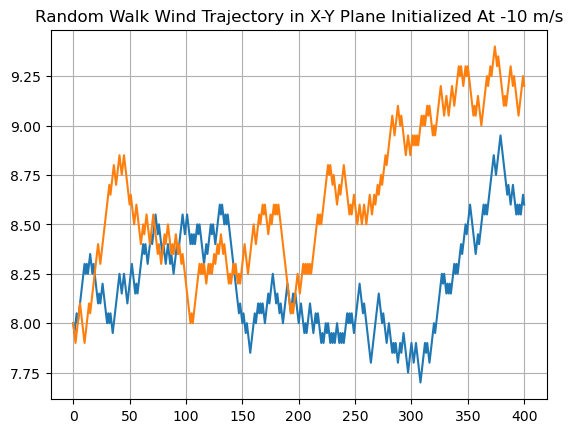

In [66]:
plt.plot(wind_vec[1, :]')
plt.plot(wind_vec[2,:]')
plt.title("Random Walk Wind Trajectory in X-Y Plane Initialized At -10 m/s")
plt.grid()

# fig = plt.figure()
# ax1 = fig.add_subplot(wind_vec[1, :]')
# ax1.set_ylabel("volts")
# ax1.set_title("a sine wave")
#plt.plot(wind_vec[3,:]')

In [67]:
# Noise to Hover Position
# Intialize Trajectory
uhist = zeros(Nu, Nt-1)
xhist = zeros(Nx, Nt)
xhist[:,1] = [ [0;0;0]; [0; 1; 0; 0]; xhover[8:10]; xhover[11:13]; 0; 0; 0; 0; 0; 0]
#xhover2 .= xhover
#xhover2[14:16] = [0;0;0] # WIND PARTS ZEROED (DOESNT MATTER IF K2 DOESNT PICK THESE TERMS)
K2 = zeros(4,18)
K2 .= K
K2[:,13:end] .= zeros(4,6)

#  [0; 1; 0; 0] xhover[1:3] +
# Forward Rollout
for k = 1:(Nt-1)
    Δx̃ = state_error(xhist[:, k], xhover)
    uhist[:, k] = uhover - K2 * Δx̃ # can't use the same K matrix here (it includes disturbance terms too...)
    #xhist[14:16, k] .= [0; 0; 0]
    xhist[14:16, k] .= [wind_vec[1, k]; wind_vec[2,k]; wind_vec[3,k]] #wind<<
    xhist[:, k+1] = drone_dynamics_RK4(xhist[:, k], uhist[:, k], h)
end
xhist;

K[:,13:end] - K2[:,13:end]

4×6 Matrix{Float64}:
 -2.72569e-5    2.53469e-5    0.00595586  …   1.87154e-6    0.000322804
 -2.57898e-10  -8.46473e-6    2.03803e-8     -1.8001e-6     1.1223e-9
  8.29193e-6    2.45637e-10   1.95221e-8      6.50012e-11   2.56583e-10
  1.0471e-7    -1.08256e-7   -1.54224e-8     -2.31516e-8   -2.26276e-8

## Hover (With Kalman):

In [68]:
# Kalman Filtering:
H_kf = I(Nx);
P_kf = Diagonal([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 100000.0, 10000.0, 10000.0, 10000.0, 100000.0])
Q_kf = Diagonal([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])
R_kf = 0.01*Diagonal([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]);

# >>
#X_kf_init = [-1.0; 1.0; 0.0; 0.0; 1; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]
X_kf_init = [ [0;0;0]; [0; 1; 0; 0]; xhover[8:10]; xhover[11:13]; 5;5; 0; 0; 0; 0]
X_ref = xhover

U_kf = zeros(Nu, Nt-1)
X_kf = zeros(Nx, Nt)
X_kf[:, 1] .= X_kf_init

est_states1 = zeros(Nx, Nt)
est_states1[:,1] .= X_kf[:,1]

#Δx̃ = state_error(X_kf[:, 2], xhover)
#Δx̃ = state_error(xhist[:,3], xhover)
uhover

4-element Vector{Float64}:
  0.26011860695351385
 -2.5063976408842713e-66
 -4.2407093693778095e-68
  0.0

In [69]:
# creating a feedforward gain matrix:
kx = 0.000001
ky = 0.000001
kz = 0.000001

Kff = [0 0 kz;
       kx 0 0;
       0 ky 0;
       0 0 0]
# doesn't work


4×3 Matrix{Float64}:
 0.0     0.0     1.0e-6
 1.0e-6  0.0     0.0
 0.0     1.0e-6  0.0
 0.0     0.0     0.0

In [70]:
# NEED TO UPDATE REFERENCE?

function update_reference(est,x_ref)
    x_ref[14:16] = -est[7:9] 
    
    return x_ref
end



update_reference (generic function with 1 method)

In [71]:
# Forward Rollout
euler = zeros(3,Nt)
error = zeros(3,Nt)
for k = 1:(Nt-1)
    #xhover = update_reference(est_states1[:,k+1],xhover)
    #Δx̃ = state_error(X_kf[:, k], xhover)
    Δx̃ = state_error(est_states1[:, k], xhover)
    error[:,k] = Δx̃[13:15]
    
#     Q = qtoQ(est_states1[4:7])
#     w_b_est = Q'*est_states1[14:16]
#     Xfus = 0.5*ρ*Sx_fux*Cd*(est_states1[8] -w_b_est[1])*(est_states1[8] - w_b_est[1])
#     Yfus = 0.5*ρ*Sy_fux*Cd*(est_states1[9] - w_b_est[2])*(est_states1[9] - w_b_est[2])
#     Zfus = 0.5*ρ*Sz_fux*Cd*(est_states1[10] - w_b_est[3])*(est_states1[10] - w_b_est[3])
    U_kf[:, k] .= uhover - K * Δx̃ #+ Kff*est_states1[7:9,k]
    X_kf[14:16, k] .= [wind_vec[1, k]; wind_vec[2,k]; wind_vec[3,k]] #wind
    X_kf[:, k+1] .= drone_dynamics_RK4(X_kf[:, k], U_kf[:, k], h)
    X_kf[14:19,k+1] .= 0.0 # ensuring that wind at the previous time step is not correlated to next time step
    est_states1[:,k+1], P_kf = update_kf_trans(est_states1[:,k], U_kf[:, k], X_kf[:, k+1], H_kf, P_kf, Q_kf, R_kf)
    
    euler[:,k] = qtoeul(X_kf[4:7,k])

    

end
#print(X_str_ref[:,1])
#print(error[:,250])
#plt.plot(error[1,:])
#plt.plot(est_states1[14,:])
#print(xhover[13,1])
#plt.grid()
print(xhover[13,1])
xhover

1.7676759805608205e-31

19-element Vector{Float64}:
  0.0
  0.0
  3.0
  0.001214042399484605
  0.9999985539250449
 -5.371838836070164e-7
  0.001190902423613995
 -2.847330366152691e-25
 -9.124020459028029e-28
 -1.2500803595667514e-24
 -6.296669134032825e-33
  3.7215369618799875e-31
  1.7676759805608205e-31
 -0.9999969755575654
 -0.9999972441495072
  1.9999716759787816
  0.0
  0.0
  0.0

In [72]:
# Δx̃ = state_error(X_kf[:, 2], xhover)

# uhover - K * Δx̃ + Kff*est_states1[7:9,2]
# #uhover - K * Δx̃ #+ Kff*est_states1[7:9,2]

In [54]:
# Plots
Pkg.add("Plots")
#comparison_plot((xhist', uhist', thist', "11"))
using PyPlot


   Resolving package versions...
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Project.toml`
  No Changes to `C:\Users\sdabir\OCRL_Project\HelicopterControl21-main\Manifest.toml`


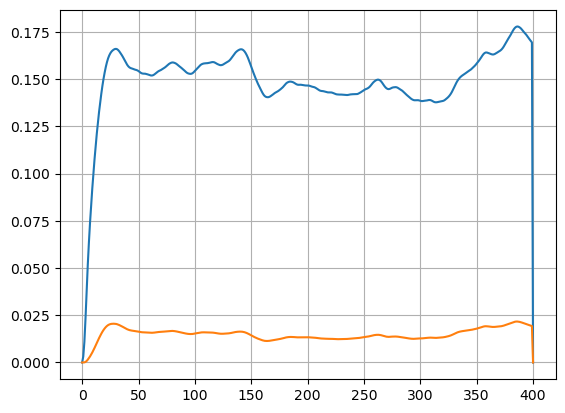

3×401 Matrix{Float64}:
 3.14159  -3.13782     -3.12876     …  -2.91879    -2.91933    0.0
 0.0       0.00314732   0.0110217       0.170162    0.16942    0.0
 0.0       3.32181e-6   6.30994e-5      0.0194693   0.0192795  0.0

In [73]:
#plt.plot(U_kf[2,:])
#euler = qtoeul(X_kf[4:7,50])
#plt.plot(euler[1,:])
plt.plot(euler[2,:])
plt.plot(euler[3,:])
plt.grid()
euler

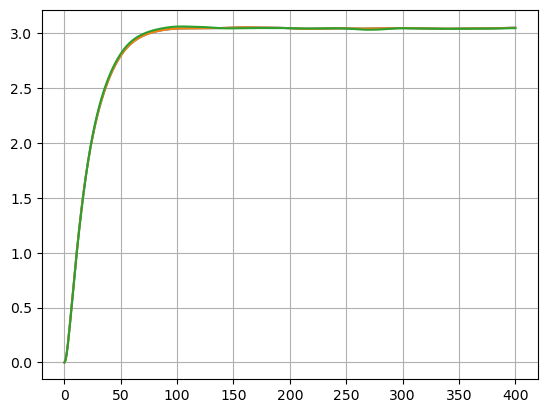

In [74]:
plt.plot(est_states1[3,:]) 
plt.plot(X_kf[3,:])
plt.plot(xhist[3,:]) 
plt.grid()
# plt.plot(xhist[3,:] - xhover[3,:])
# plt.plot(Δx̃[1,:])
# plt.plot(Δx̃[2,:])
# plt.plot(Δx̃[3,:])

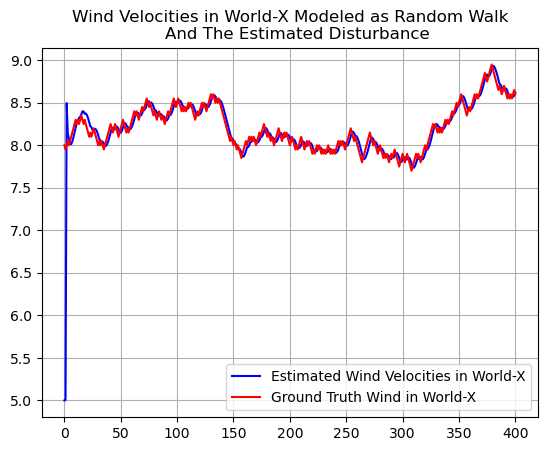

PyObject Text(0.5, 1.0, 'Wind Velocities in World-X Modeled as Random Walk\n    And The Estimated Disturbance ')

In [75]:
plt.plot(est_states1[14,:],"blue")
plt.plot(wind_vec[1,:],"red")
plt.legend(["Estimated Wind Velocities in World-X","Ground Truth Wind in World-X"])
#plt.legend(["Estimated Wind Velocities","Ground Truth Wind in World-Y"])
plt.grid()
plt.title("Wind Velocities in World-X Modeled as Random Walk
    And The Estimated Disturbance ")
# plt.grid()

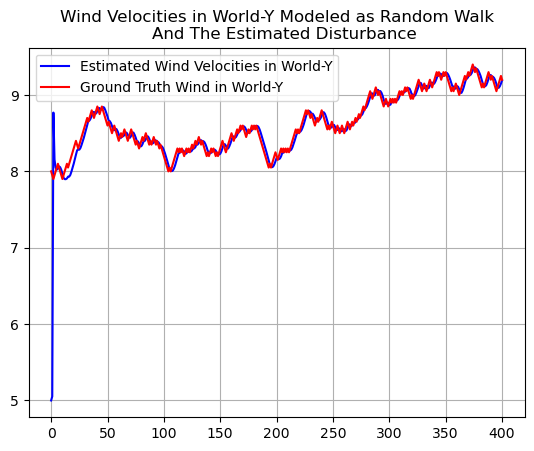

PyObject Text(0.5, 1.0, 'Wind Velocities in World-Y Modeled as Random Walk\n    And The Estimated Disturbance ')

In [76]:
plt.plot(est_states1[15,:],"blue")
plt.plot(wind_vec[2,:],"red")
plt.legend(["Estimated Wind Velocities in World-Y","Ground Truth Wind in World-Y"])
plt.grid()
plt.title("Wind Velocities in World-Y Modeled as Random Walk
    And The Estimated Disturbance ")

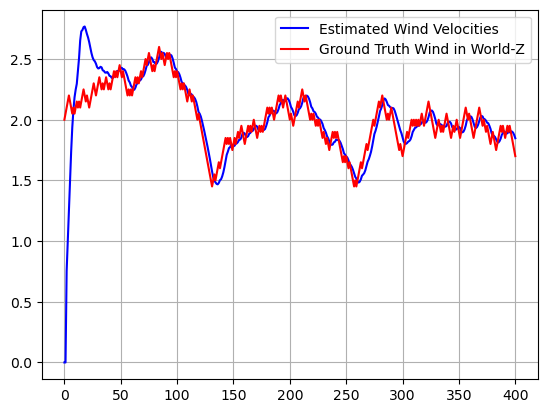

In [77]:
plt.plot(est_states1[16,:],"blue")
plt.plot(wind_vec[3,:],"red")
plt.legend(["Estimated Wind Velocities","Ground Truth Wind in World-Z"])
plt.grid()

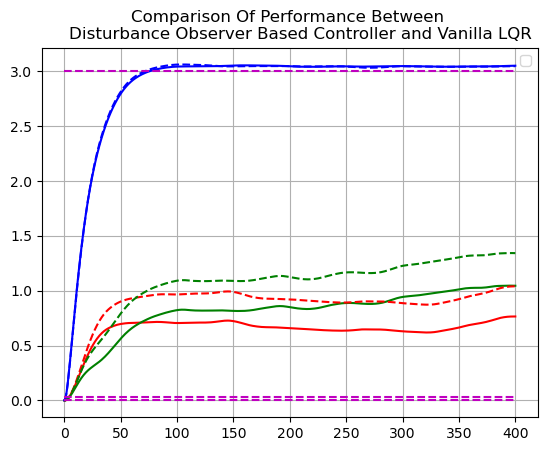

In [78]:
X_REF = zeros(1,Nt)
Y_REF = zeros(1,Nt)
Z_REF = zeros(1,Nt)

for i=1:Nt
    Y_REF[1,i] = 0.03 
    Z_REF[1,i] = 3.0
end
#plt.plot(uhist[1,:])
plt.legend(["Thrust"])
#plt.plot(uhist[1,:])

# With Kalman Filter

plt.plot(X_kf[1,:],"red")
plt.plot(X_kf[2,:],"green")
plt.plot(X_kf[3,:],"blue")


# Without Kalman Filter
plt.plot(xhist[1,:],"r--")
plt.plot(xhist[2,:],"g--")
plt.plot(xhist[3,:],"b--")
#plt.legend(["X","Y","Z")
#plt.legend(["Z Without DOb"])

plt.plot(X_REF[1,:],"m--")
plt.plot(Y_REF[1,:],"m--")
plt.plot(Z_REF[1,:],"m--")

#plt.legend(["Estimated Wind Velocities","Ground Truth Wind in World-Z",])
plt.title("Comparison Of Performance Between 
    Disturbance Observer Based Controller and Vanilla LQR")
plt.grid()

#the difference between two performances is very little! Need to make sure the wind "knowledge"
#is used to take control input decisions.
##############
#=
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(2,3,4) # plot the point (2,3,4) on the figure
plt.show()
=#
##############


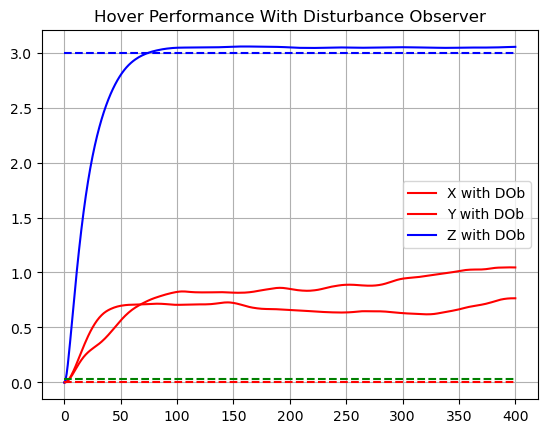

In [79]:
X_REF = zeros(1,Nt)
Y_REF = zeros(1,Nt)
Z_REF = zeros(1,Nt)

for i=1:Nt
    Y_REF[1,i] = 0.03 
    Z_REF[1,i] = 3.0
end

plt.plot(X_kf[1,:],"red")
plt.plot(X_kf[2,:],"red")
plt.plot(X_kf[3,:],"blue")
plt.plot(X_REF[1,:],"r--")
plt.plot(Y_REF[1,:],"g--")
plt.plot(Z_REF[1,:],"b--")
#plt.legend(["X-Setpoint","Y-Setpoint","Z-Setpoint"])
plt.legend(["X with DOb","Y with DOb","Z with DOb"])


plt.title("Hover Performance With Disturbance Observer")

plt.grid()
# plt.plot(X_kf[1,:],"red")
# plt.plot(X_kf[2,:],"yellow")
# plt.plot(X_kf[3,:],"blue")

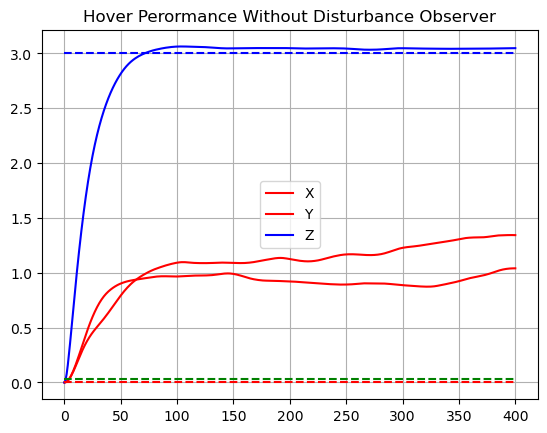

In [80]:
plt.plot(xhist[1,:],"red")
plt.plot(xhist[2,:],"red")
plt.plot(xhist[3,:],"blue")
plt.plot(X_REF[1,:],"r--")
plt.plot(Y_REF[1,:],"g--")
plt.plot(Z_REF[1,:],"b--")

plt.legend(["X","Y","Z"])
plt.title("Hover Perormance Without Disturbance Observer")
plt.grid()

In [81]:
vis = Visualizer()
set_heli_model!(vis)
render(vis)


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat C:\Users\sdabir\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("TailRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x54, 0x61, 0x69, 0x6c, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Chassis" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x6d, 0x2f, 0x43, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Rotorshaft" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x6f, 0x74, 0x6f, 0x72, 0x73, 0x68, 0x61, 0x66, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "MainRotor" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4d, 0x61, 0x69, 0x6e, 0x52, 0x6f, 0x74, 0x6f, 0x72], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8701))

In [82]:
anim = animate(vis, xhist, thist, h)
setanimation!(vis, anim)
#setanimation!(vis2, anim)



In [783]:
anim2 = animate(vis, X_kf, thist, h)
setanimation!(vis, anim2)

## TODO: Straight Line Trajectory:

In [65]:
# # Straight Line Trajectory
# using Random
# ir, iq, iv, iw = state_parts()
# #[-10.1; 0.0; 5.0; 0.0; 1; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0; 0; 0; 0; 0; 0];
# # [-10.1; 0.0; 5.0; 0.25881; 0.9659; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0; 0; 0; 0; 0; 0]
# X_str_init = [-1.0; 1.0; 0.0; 0.0; 1; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0; 0; 0; 0; 0; 0]; #add wind into the reference traj
# X_str_final = xhover #add to final so interpolation keeps it constant
# U_str_ref = zeros(Nu, Nt-1)
# X_str_ref = zeros(Nx, Nt)

# X_str_ref[:, 1] = X_str_init

# dx_str = (X_str_final[ir] - X_str_init[ir]) / (Nt - 1)

# # Find reference trajectory?
# for k = 1:Nt-1
#     U_str_ref[:, k] = uhover
#     X_str_ref[ir, k+1] = X_str_ref[ir, k] + dx_str
#     dq_str = normalize(slerp(normalize(Quaternion(X_str_init[4], X_str_init[5:7])), normalize(Quaternion(X_str_final[4], X_str_final[5:7])), ((k-1)/(Nt-1))))
#     X_str_ref[iq, k] = [dq_str.s; dq_str.v1; dq_str.v2; dq_str.v3]
#     X_str_ref[iv, k] = (X_str_ref[ir, k+1] - X_str_ref[ir, k]) / h
#     # Need to fix Angular Velocity
# #     X_str_ref[iw, k] = [0;-pi/10;0]
# end
# X_str_ref[:, end] = X_str_final

# # Tracking
# U_str = zeros(Nu, Nt-1)
# X_str = zeros(Nx, Nt)
# X_str[:, 1] .= X_str_init

# wind_vec = zeros(3, Nt)
# wind_vec[:,1] .= [0;0;0]#[40;40]
# Random.seed!(1234);
# for i = 1:Nt-1
#     wind_vec[:, i+1] .= wind_vec[:, i] .+ [rand((-10*h, 10*h)), rand((-10*h, 10*h)), rand((-10*h, 10*h))] 
#     #wind_vec[:, i+1] .= wind_vec[:, i] .+ [0.0, 0.0]
# end

# H_kf = I(Nx);
# P_kf = Diagonal([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 100000.0, 10000.0, 10000.0, 10000.0, 100000.0])
# Q_kf = Diagonal([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0])
# R_kf = 0.01*Diagonal([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]);

# est_states1 = zeros(Nx, Nt)
# est_states1[:,1] .= X_str[:,1]

# for k = 1:(Nt-1)
#     Δx̃ = state_error(X_str[:, k], X_str_ref[:, k])
#     U_str[:, k] .= U_str_ref[:, k] - K * Δx̃ 
#     X_str[14:16, k] .= [wind_vec[1, k]; wind_vec[2,k]; wind_vec[3,k]] #wind
#     X_str[:, k+1] .= drone_dynamics_RK4(X_str[:, k], U_str[:, k], h)
#     X_str[14:19,k+1] .= 0.0 # ensuring that wind at the previous time step is not correlated to next time step
#     est_states1[:,k+1], P_kf = update_kf_trans(est_states1[:,k], U_str[:, k], X_str[:, k+1], H_kf, P_kf, Q_kf, R_kf)
# end
# print(X_str_ref[:,1])

[-1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.049999999999998934, -0.049999999999998934, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]